In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gd
import sys
#sys.path.append('../topotests/')
import bifiltrations_alpha as alpha
#from distributions import MultivariateDistribution, GaussianMixture, AbsoluteDistribution
import scipy.stats as st

In [2]:
# claulate the distance between two ECC
# in fact this is integrated squared difference between two picewise constant functions
def get_ecc_distance(ecc0, ecc1):
    # ecc0 and ecc1 are the picewise constant functions - each element is a (x, y) tuple
    # and represents a jump of the function. segment is created using the x position of the next jump
    ecc0 = np.array(ecc0)
    ecc1 = np.array(ecc1)
    # find the largest x value - this will determine the range of integration
    xlim = max(np.max(ecc0[:, 0]), np.max(ecc1[:, 0]))
    # add one segment to each function so that ecc0 and ecc1 have the same support
    ecc0 = np.vstack([ecc0, [xlim, ecc0[-1, 1]]])
    ecc1 = np.vstack([ecc1, [xlim, ecc1[-1, 1]]])
    # ecc0 and ecc1 have jumps in different locations
    # the difference ecc0-ecc1 is approximaed by step picewise constant function, hence we
    # need to find all possible jumps of ecc0 and ecc1
    bin_domain = np.unique(np.sort(np.concatenate([ecc0[:, 0], ecc1[:, 0]])))
    ecc_diff = np.zeros_like(bin_domain)
    # now we need to have y-value of ecc0 and ecc1 in the combined jumps locations
    for id_b, b in enumerate(bin_domain):
        id0 = np.argmax(ecc0[:, 0] > b)-1 # FIXME: there must be a faster way
        id1 = np.argmax(ecc1[:, 0] > b)-1
        ecc_diff[id_b] = ecc0[id0, 1] - ecc1[id1, 1] # differnece of ecc0 and ecc1
    ecc_dist = 0
    id_val = 0
    for bl, br in zip(bin_domain[:-1], bin_domain[1:]):
        # changed L1 to L2
        # ecc_dist += ecc_diff[id_val]**2*(br-bl) # L2
        ecc_dist += abs(ecc_diff[id_val]*(br-bl)) # L1
        id_val += 1
    return ecc_dist

In [3]:
# test distance function on some artificial data
def plot_stepfunction(dat, color='black'):
    # ugly hack
    x = [d[0] for d in dat]
    y = [d[1] for d in dat]
    id_val = 0
    for bl, br in zip(x[:-1], x[1:]):
        yval = y[id_val]
        id_val+=1
        plt.plot([bl, br], [yval, yval], color=color)

# lists below represtent two step-functions
# last point shows were the data ends
f1 = [[0, 0], [1.5, 2], [3.5, 1], [4.5, 3], [5.5, 0], [6, 0]]
f2 = [[0, 0], [1, 1], [2, 2], [4, 4], [6, 4]]

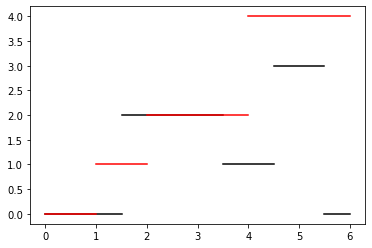

In [4]:
plot_stepfunction(f1)
plot_stepfunction(f2, color='red')
plt.show()

<AxesSubplot:xlabel='Filtration', ylabel='Euler Characteristic'>

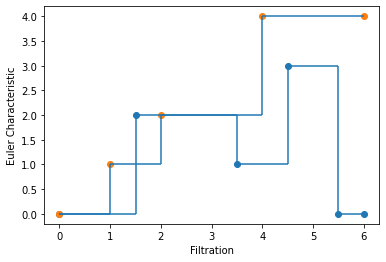

In [5]:
# we can use the plotting in bifiltrations_alpha
alpha.plot_ECC(f1, with_lines=True)
alpha.plot_ECC(f2, with_lines=True)

In [6]:
get_ecc_distance(f1, f2)

6.0

In [7]:
alpha.get_ecc_distance_from_contributions(f1, f2)

6.0

In [8]:
# calculate distance manually x*y
# 0.5*1 + 0.5*1 + 0.5*1 + 0.5*(4-1)**2 + 1*(4-3)**2 + 0.5*(4-0)**2 # L2
0.5*1 + 0.5*1 + 0.5*1 + 0.5*(4-1) + 1*(4-3) + 0.5*(4-0) # L1

6.0

In [9]:
# do calculations for eccs

In [10]:
points0 = pd.read_csv('test.csv')
# get some simple artificial data
points1 = points0*2

In [11]:
ecc_contributions0, num_simplices = alpha.compute_ECC_contributions_alpha(points0.values)
ecc0 = alpha.ECC_from_contributions(ecc_contributions0)
ecc_contributions1, num_simplices = alpha.compute_ECC_contributions_alpha(points1.values)
ecc1 = alpha.ECC_from_contributions(ecc_contributions1)

In [12]:
%%timeit
get_ecc_distance(ecc0, ecc1)

47 ms ± 7.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
alpha.get_ecc_distance_from_contributions(ecc_contributions0, ecc_contributions1)

4.4 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
# consistency check
print(get_ecc_distance(ecc0, ecc1) == alpha.get_ecc_distance_from_contributions(ecc_contributions0, 
                                                                                ecc_contributions1))

True


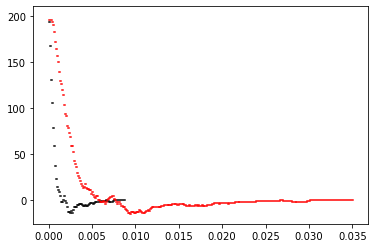

In [15]:
plot_stepfunction(ecc0)
plot_stepfunction(ecc1, color='red')

<AxesSubplot:xlabel='Filtration', ylabel='Euler Characteristic'>

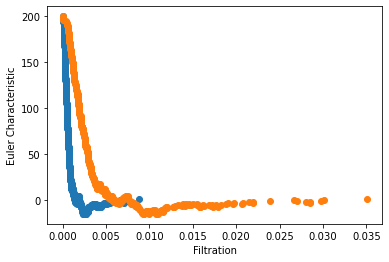

In [16]:
# we can use the plotting in bifiltrations_alpha
alpha.plot_ECC(ecc0)
alpha.plot_ECC(ecc1)

## Binning

In [17]:
grid = np.linspace(0, 0.04, num=41)
ecc_contributions_grid0 = alpha.project_contributions_to_grid(ecc_contributions0,
                                                              grid)

ecc_contributions_grid1 = alpha.project_contributions_to_grid(ecc_contributions1,
                                                              grid)

<AxesSubplot:xlabel='Filtration', ylabel='Euler Characteristic'>

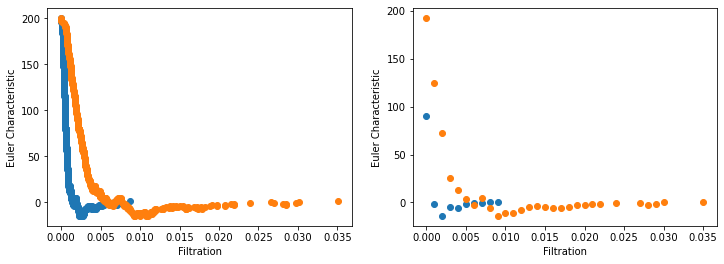

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
alpha.plot_ECC(ecc0, this_ax=ax[0])
alpha.plot_ECC(ecc1, this_ax=ax[0])

alpha.plot_ECC(alpha.ECC_from_contributions(ecc_contributions_grid0), 
               this_ax=ax[1])
alpha.plot_ECC(alpha.ECC_from_contributions(ecc_contributions_grid1), 
               this_ax=ax[1])

In [19]:
# now computing distances is way faster 

In [20]:
%%timeit
alpha.get_ecc_distance_from_contributions(ecc_contributions_grid0, ecc_contributions_grid1)

199 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
exact_diff = alpha.get_ecc_distance_from_contributions(ecc_contributions0, ecc_contributions1)
approx_diff = alpha.get_ecc_distance_from_contributions(ecc_contributions_grid0, ecc_contributions_grid1)

print('exact  diff {:.3f}'.format(exact_diff))
print('approx diff {:.3f}'.format(approx_diff))

exact  diff 0.475
approx diff 0.506
